In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
from cmcrameri import cm
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\amp\clim'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\amp\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')


In [10]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [11]:
#create a dictionary withh all datasets
vmin = 250
vmax = 650
levels = 9
proj = ccrs.Mercator()
extend = [-81, -42, -20, 11]
cmap = cm.lapaz_r
bounds = np.linspace(vmin,vmax, levels)
extend_cmap = 'both'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cmap )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []


C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\1424951754.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


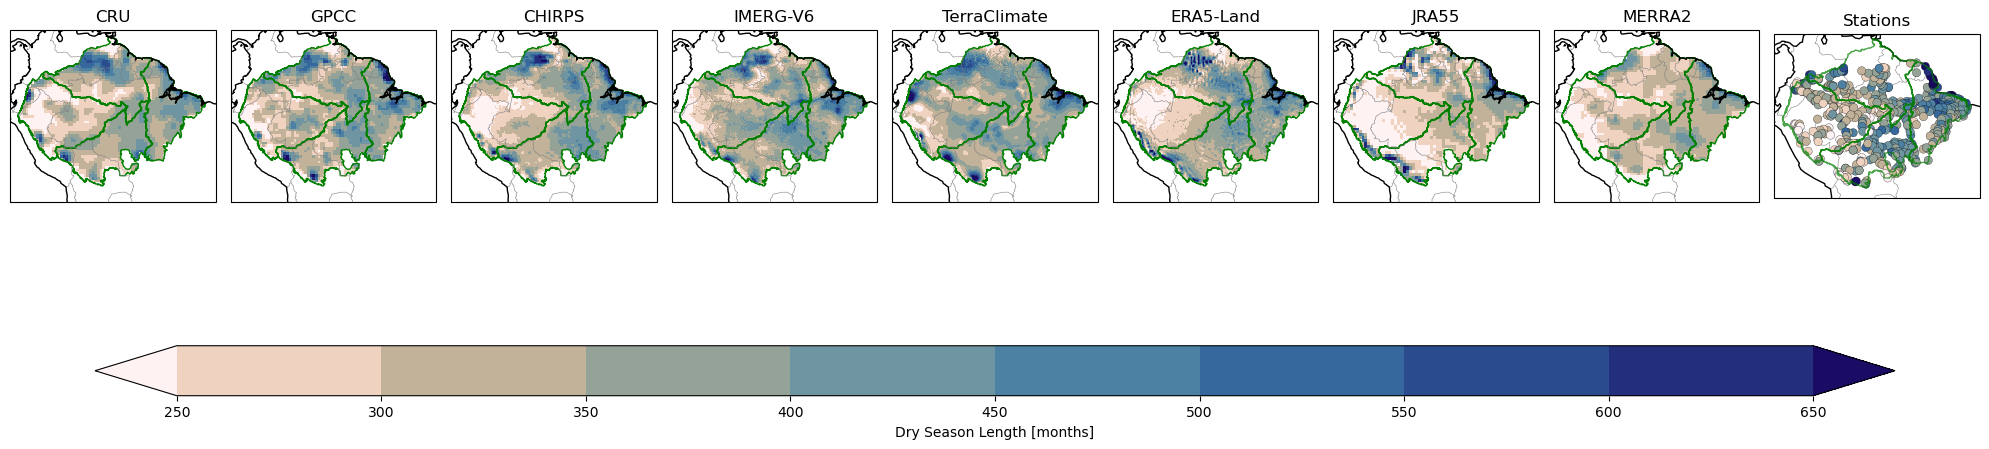

In [12]:
# Create a figure and a gridspec layout
fig , axes = plt.subplots(1, len(datasets)+1, figsize=(20, 5), subplot_kw={'projection': proj})

#color bar
cax = fig.add_axes([0.05, -0.06, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Dry Season Length [months]')

# Loop through the datasets and plot them
for i, name in enumerate(datasets_names):
    # Create an axis for the subplot
    ax = axes[i]
    ds = ds_dict[name].amp
    im = ds.where(ds>0).plot(ax=ax, cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels, extend=extend_cmap )
    ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
    ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)    
    axes[i].set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_extent(extend)
    ax.coastlines()
    ax.set_title(name)
    
ax_stat = axes[-1]
#set projection to ccrc.PlateCarree() of ax_stat
ax_stat.coastlines(transform=ccrs.PlateCarree())
ax_stat.add_geometries(cf.BORDERS.geometries(), crs=proj, linewidth=0.4, edgecolor='grey', facecolor='none',zorder=0)
ax_stat.add_geometries(cf.COASTLINE.geometries(), crs=proj, linewidth=1, edgecolor='black', facecolor='none',zorder=0)
stations.plot(ax=ax_stat, column='amp', cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black')
ax_stat.set_title('Stations')   
regions.plot(ax=ax_stat, facecolor='none', edgecolor='green', linewidth=1, alpha=0.7)

ax_stat.set_xlim(-81, -42)
ax_stat.set_ylim(-20, 11)

plt.tight_layout()

# EDA


C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\2353013310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\2353013310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\2353013310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\2353013310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_15232\2353013310.py:6: FutureWarning: The frame.append method is dep

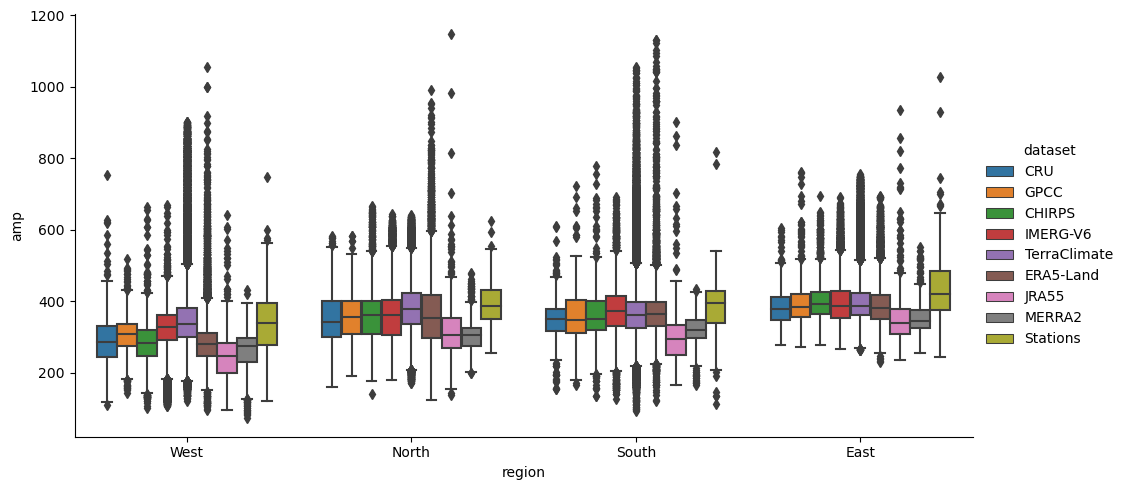

In [8]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['dataset'] = name
    df = df.append(dff)
df = df[['amp', 'region', 'dataset']]
df['region'] = df['region'].replace({0:'West', 1:'North', 2:'South', 3:'East'})
df_stat = stations[['amp', 'Region']].copy()
df_stat['dataset'] = 'Stations'
df_stat = df_stat.rename(columns={'Region':'region'})
df = df.append(df_stat)
sns.catplot(hue='dataset', y='amp', data=df, kind='box', height=5, aspect=2,  x='region')